# 03 — WISDM predobdelava: čiščenje + segmentiranje v okna (npr. 5 s)

1) naloži RAW A/B podatke (phone accel)
2) očisti (sortiranje, dvojniki, NaN, tipični sanity checks)
3) segmentira v **okna** (privzeto 5 s) z opcijskim overlapom
4) vsakemu oknu dodeli oznako (A=0, B=1) z večinskim glasovanjem in kakovostnimi filtri
5) shrani:
- `prepared/windows_5s_50pct_*.npz` (okna kot `N x T x 3` array)
- `prepared/windows_5s_50pct_*_meta.parquet` (meta + label per window)


## 0) Nastavitve


In [10]:
from pathlib import Path
import numpy as np
import pandas as pd

DATA_DIR = Path(r"/Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset")
assert DATA_DIR.exists(), f"DATA_DIR ne obstaja: {DATA_DIR}"

IN_PATH = DATA_DIR / "prepared" / "raw_phone_accel_walk_jog.parquet"
assert IN_PATH.exists(), f"Ne najdem pripravljene datoteke iz notebooka 02: {IN_PATH}"

OUT_DIR = DATA_DIR / "prepared"
OUT_DIR.mkdir(exist_ok=True)

print("IN_PATH:", IN_PATH)
print("OUT_DIR:", OUT_DIR)


IN_PATH: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared/raw_phone_accel_walk_jog.parquet
OUT_DIR: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared


## 1) Naloži podatke
Pričakovani stolpci: `subject_id, activity_code, timestamp, x, y, z, label`.


In [11]:
raw = pd.read_parquet(IN_PATH)
raw.info()
raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39482 entries, 0 to 39481
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject_id     39482 non-null  int64  
 1   activity_code  39482 non-null  object 
 2   timestamp      39482 non-null  int64  
 3   x              39482 non-null  float64
 4   y              39482 non-null  float64
 5   z              39482 non-null  float64
 6   activity_name  39482 non-null  object 
 7   label          39482 non-null  int8   
dtypes: float64(3), int64(2), int8(1), object(2)
memory usage: 2.1+ MB


,subject_id,activity_code,timestamp,x,y,z,activity_name,label
0,1600,B,251987619821922,1.375549,15.375046,2.971619,jogging,1
1,1600,B,251987670175926,-3.934433,17.538788,2.110016,jogging,1
2,1600,B,251987720529930,-0.087738,12.791565,-1.454102,jogging,1
3,1600,B,251987770883934,2.038742,3.077148,-1.053726,jogging,1
4,1600,B,251987821237937,-2.558472,-2.738678,-2.098511,jogging,1


## 2) Čiščenje (cleaning)
- popravimo tipe
- odstranimo NaN v x/y/z
- odstranimo duplikate (`subject_id`, `timestamp`)
- uredimo po času


In [12]:
raw["subject_id"] = pd.to_numeric(raw["subject_id"], errors="coerce").astype("Int64")
raw["timestamp"]  = pd.to_numeric(raw["timestamp"], errors="coerce")

raw = raw.dropna(subset=["subject_id", "timestamp", "x", "y", "z", "label", "activity_code"]).copy()
raw = raw.drop_duplicates(subset=["subject_id", "timestamp"]).copy()
raw = raw.sort_values(["subject_id", "timestamp"]).reset_index(drop=True)

print("Po čiščenju:", raw.shape)
raw.head()


Po čiščenju: (39482, 8)


,subject_id,activity_code,timestamp,x,y,z,activity_name,label
0,1600,B,251987619821922,1.375549,15.375046,2.971619,jogging,1
1,1600,B,251987670175926,-3.934433,17.538788,2.110016,jogging,1
2,1600,B,251987720529930,-0.087738,12.791565,-1.454102,jogging,1
3,1600,B,251987770883934,2.038742,3.077148,-1.053726,jogging,1
4,1600,B,251987821237937,-2.558472,-2.738678,-2.098511,jogging,1


### 2.1) Sanity checks
- razredi
- subjekti


In [13]:
print("activity_code counts:")
print(raw["activity_code"].value_counts())

print("\nlabel counts:")
print(raw["label"].value_counts())

print("\nTop subjects by samples:")
print(raw["subject_id"].value_counts().head(10))


activity_code counts:
activity_code
B    19741
A    19741
Name: count, dtype: int64

label counts:
label
1    19741
0    19741
Name: count, dtype: int64

Top subjects by samples:
subject_id
1601    9024
1603    9022
1600    7146
1604    7146
1602    7144
Name: count, dtype: Int64


## 3) Segmentiranje v okna (sample-based)
Privzamemo sampling rate ~20 Hz.

- WINDOW_SEC = 5s → WINDOW_SIZE = 100
- OVERLAP = 0.5 → STEP_SIZE = 50


In [14]:
SAMPLING_RATE = 20
WINDOW_SEC = 5
OVERLAP = 0.5

WINDOW_SIZE = int(SAMPLING_RATE * WINDOW_SEC)
STEP_SIZE   = int(WINDOW_SIZE * (1.0 - OVERLAP))

print("WINDOW_SIZE:", WINDOW_SIZE)
print("STEP_SIZE:", STEP_SIZE)


WINDOW_SIZE: 100
STEP_SIZE: 50


### 3.1) Funkcija za okna + majority label + purity filter
NOTE TO SELF: Purity pomeni, koliko % vzorcev v oknu pripada večinskemu razredu.
Če je purity < threshold, okno zavržemo (ker je verjetno prehod).


In [15]:
from typing import Tuple

def make_windows_majority(
    df: pd.DataFrame,
    window_size: int,
    step_size: int,
    purity_threshold: float = 0.80
) -> Tuple[np.ndarray, pd.DataFrame]:
    windows = []
    metas = []

    for sid, g in df.groupby("subject_id"):
        g = g.sort_values("timestamp")
        xyz = g[["x","y","z"]].to_numpy(dtype=np.float32)
        labels = g["label"].to_numpy(dtype=np.int8)
        ts = g["timestamp"].to_numpy()

        n = len(g)
        if n < window_size:
            continue

        for start in range(0, n - window_size + 1, step_size):
            end = start + window_size
            win_xyz = xyz[start:end]
            win_labels = labels[start:end]

            counts = np.bincount(win_labels, minlength=2)
            maj_label = int(np.argmax(counts))
            purity = float(counts[maj_label] / window_size)

            if purity < purity_threshold:
                continue

            windows.append(win_xyz)
            metas.append({
                "subject_id": int(sid),
                "start_idx": int(start),
                "end_idx": int(end),
                "start_ts": float(ts[start]),
                "end_ts": float(ts[end-1]),
                "label": maj_label,
                "purity": purity
            })

    if not windows:
        return np.empty((0, window_size, 3), dtype=np.float32), pd.DataFrame(columns=[
            "subject_id","start_idx","end_idx","start_ts","end_ts","label","purity"
        ])

    return np.stack(windows), pd.DataFrame(metas)


### 3.2) Ustvari okna
Če dobiš premalo oken, znižaj `PURITY` na 0.7.


In [16]:
PURITY = 0.80

wins, meta = make_windows_majority(raw, WINDOW_SIZE, STEP_SIZE, purity_threshold=PURITY)

print("Windows shape:", wins.shape)
print("Meta shape:", meta.shape)
meta.head()


Windows shape: (773, 100, 3)
Meta shape: (773, 7)


,subject_id,start_idx,end_idx,start_ts,end_ts,label,purity
0,1600,0,100,2.519876e+14,2.519926e+14,1,1.0
1,1600,50,150,2.519901e+14,2.519951e+14,1,1.0
2,1600,100,200,2.519927e+14,2.519976e+14,1,1.0
3,1600,150,250,2.519952e+14,2.520002e+14,1,1.0
4,1600,200,300,2.519977e+14,2.520027e+14,1,1.0


### 3.3) Razredi po oknih + purity statistika


In [17]:
print("Window label counts:")
print(meta["label"].value_counts())

print("\nPurity summary:")
print(meta["purity"].describe())


Window label counts:
label
0    387
1    386
Name: count, dtype: int64

Purity summary:
count    773.000000
mean       0.999715
std        0.005615
min        0.880000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: purity, dtype: float64


## 4) (Opcijsko) Uravnoteženje (undersampling)
Če je jogging razred redkejši, lahko narediš uravnotežen set.
Alternativa je, da se v modelu uporabi `class_weight`.


In [18]:
BALANCE = False
SEED = 42

if BALANCE and len(meta):
    rng = np.random.default_rng(SEED)
    idx0 = meta.index[meta["label"] == 0].to_numpy()
    idx1 = meta.index[meta["label"] == 1].to_numpy()
    n = min(len(idx0), len(idx1))

    keep0 = rng.choice(idx0, size=n, replace=False)
    keep1 = rng.choice(idx1, size=n, replace=False)
    keep = np.concatenate([keep0, keep1])
    keep.sort()

    wins = wins[keep]
    meta = meta.iloc[keep].reset_index(drop=True)

    print("Balanced windows:", wins.shape)
    print("Label counts:", meta["label"].value_counts().to_dict())
else:
    print("BALANCE =", BALANCE, "- brez sprememb.")


BALANCE = False - brez sprememb.


## 5) Shrani rezultate


In [19]:
import numpy as np

tag = f"{WINDOW_SEC}s_{int(OVERLAP*100)}pct_purity{int(PURITY*100)}"
npz_path = OUT_DIR / f"windows_{tag}.npz"
meta_path = OUT_DIR / f"windows_{tag}_meta.parquet"

np.savez_compressed(npz_path, wins=wins)
meta.to_parquet(meta_path, index=False)

print("Saved:", npz_path)
print("Saved:", meta_path)


Saved: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared/windows_5s_50pct_purity80.npz
Saved: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared/windows_5s_50pct_purity80_meta.parquet


## 6) Hiter plot (sanity check)


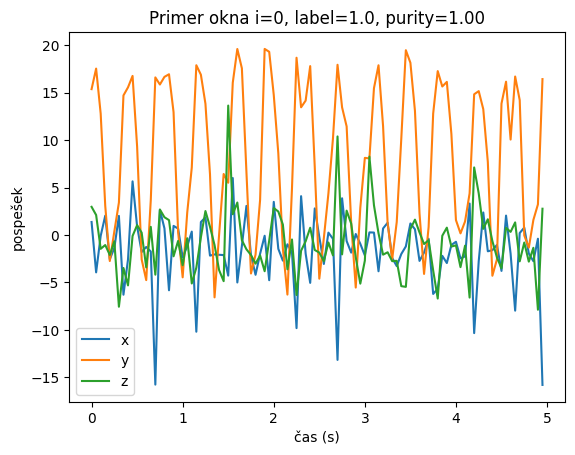

In [20]:
import matplotlib.pyplot as plt

if len(wins) > 0:
    i = 0
    w = wins[i]
    t = np.arange(len(w)) / SAMPLING_RATE

    plt.figure()
    plt.plot(t, w[:,0], label="x")
    plt.plot(t, w[:,1], label="y")
    plt.plot(t, w[:,2], label="z")
    plt.xlabel("čas (s)")
    plt.ylabel("pospešek")
    plt.title(f"Primer okna i={i}, label={meta.iloc[i]['label']}, purity={meta.iloc[i]['purity']:.2f}")
    plt.legend()
    plt.show()
else:
    print("Ni oken — znižaj purity_threshold ali preveri input podatke.")


#### NOTE TO SELF:

**Kaj vidimo na grafu?**

- Trajanje ~5 s → pravilno okno (WINDOW_SEC = 5)

- Label = 1 (jogging) → smiselno glede na signal

- Purity = 1.00 → v oknu ni prehodov, vse pripada istemu razredu (idealno za učenje)

**Zakaj signal izgleda “prav”**

- y-os ima največjo amplitudo (~15–20) → to je zelo tipično, ker ena os pogosto nosi gravitacijo + vertikalno gibanje (telefon v žepu, jogging)

- Periodičen vzorec → jasni “vrhovi” ponavljajočih se korakov → klasičen jogging

- x in z bolj šumasta, manjša amplituda → lateralni in naprej–nazaj premiki, normalno

- Ni saturacije, ni konstantnih linij, ni NaN → senzorni podatki so zdravi

**Kaj to pomeni za tvoj pipeline?**

To potrjuje, da:

- segmentiranje deluje

- purity filter dela pravilno

- okna so fizično smiselna

- lahko mirno nadaljuješ na feature extraction